In [4]:
import cv2
import sqlite3
import numpy
import statistics 
import sys
import os
import json
import time
import sys
from numpy.lib.function_base import append
import xlsxwriter
import matplotlib.pyplot as plt
from os.path import join
import numpy as np
import pandas as pd
import math
from mpl_toolkits.mplot3d import Axes3D
from _collections import deque
from scipy.signal import argrelextrema
import glob

In [5]:
##Computing least-squares solution to equation Ax = b
def plane_fitting_max_point(x,y,z):
    y = y
    x = x
    z = z
    num_points = len(x)
    z_step_size = 1.875

    # plot raw data
#     plt.figure()
    ax = plt.subplot(111, projection='3d')
    ax.scatter(x, y, z, color='b')

    tmp_A = []
    tmp_b = []
    for i in range(len(x)):
        tmp_A.append([x[i], y[i], 1])
        tmp_b.append(z[i])

    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)

    from scipy.linalg import lstsq
    fit, residual, rnk, s = lstsq(A, b)
    errors =  A * fit - b
    plane_z = A * fit
    
    index_min_plane_z = np.argmin(plane_z)
    index_max_plane_z = np.argmax(plane_z)
#     print("min_x in list: ", index_min_plane_z, " z value: ", plane_z[index_min_plane_z], " actual min z: ", min(plane_z))
#     print("min_x in list: ", index_max_plane_z, " z value: ", plane_z[index_max_plane_z], " actual min z: ", max(plane_z))

    x_z_min_in_microns = x[index_min_plane_z]
    x_z_max_in_microns = x[index_max_plane_z]
    y_z_min_in_microns = y[index_min_plane_z]
    y_z_max_in_microns = y[index_max_plane_z]

    max_plane_z_diff  = max(plane_z) - min(plane_z)
    
    slope = (max(plane_z) - min(plane_z))/(math.dist([x_z_max_in_microns, y_z_max_in_microns], [x_z_min_in_microns, y_z_min_in_microns]))
    print("Slope: ", slope)
#     print("max_plane_z_diff: ", max_plane_z_diff)
    print("solution: %f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))

# #    plot plane
#     xlim = ax.get_xlim()
#     ylim = ax.get_ylim()
#     X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
#                       np.arange(ylim[0], ylim[1]))
#     Z = np.zeros(X.shape)
#     for r in range(X.shape[0]):
#         for c in range(X.shape[1]):
#             Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
#     ax.plot_wireframe(X,Y,Z, color='k')
    
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('z')
#     plt.show()
    return(fit)

Slope:  [[0.00025787]]
solution: 0.000092 x + -0.000299 y + 8932.866224 = z
Slope:  [[0.00083111]]
solution: 0.000203 x + -0.000902 y + 8950.109862 = z


,slide_name,slope_x_bel,slope_y_bel,z_shift_bel,slope_x_abv,slope_y_abv,z_shift_abv
0,JR-20-621-A2-1_H01BBB20P-15245,0.000092,-0.000299,8932.866224,0.000203,-0.000902,8950.109862


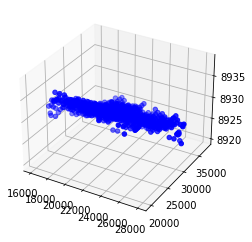

In [6]:
lsta = []
lstb = []
final_lst_blw = []
final_lst_abv = []

filedb = '/home/adminspin/Desktop/Planarity/JR-20-621-A2-1_H01BBB20P-15245/JR-20-621-A2-1_H01BBB20P-15245.db'
slide_name = filedb.split('/')[-1].split('.')[0]
# print(slide_name)
conn = sqlite3.connect(filedb)
c = conn.cursor()
query = "select grid_id, best_rows_ima from grid_info where grid_status = 10"
c.execute(query)
aoi_info = c.fetchall()
db = pd.DataFrame(aoi_info)
db.rename(columns = {0:'grid_id',1:'best_row'}, inplace = True)

query1 = "select aoi_name, slide_row_idx, aoi_x_mic, aoi_y_mic, best_z, grid_id from aoi where focus_metric > 7 and color_metric > 40 and bg_state_acq = 0"
c.execute(query1)
aoi_info = c.fetchall()
df = pd.DataFrame(aoi_info)
df.rename(columns = {0:'aoi_name',1:'slide_row_idx',2:'aoi_x_mic',3:'aoi_y_mic',4:'best_z',5:'grid_id'}, inplace = True)

final_df = pd.DataFrame(columns = ("slide_name","slope_x_bel","slope_y_bel","z_shift_bel","slope_x_abv","slope_y_abv","z_shift_abv"))

for i in db['grid_id'].unique():
        row = db[db['grid_id'] == i].iloc[0,1]

        df_low0 = df[df['grid_id'] == i]
        df_low = df_low0[df_low0['slide_row_idx'] > int(row)]
        x = df_low['aoi_x_mic'].tolist()
        y = df_low['aoi_y_mic'].tolist()
        z = df_low['best_z'].tolist()

        df_high0 = df[df['grid_id'] == i]
        df_high = df_high0[df_high0['slide_row_idx'] < int(row)]
        x1 = df_high['aoi_x_mic'].tolist()
        y1 = df_high['aoi_y_mic'].tolist()
        z1 = df_high['best_z'].tolist()
        plane_below = plane_fitting_max_point(x,y,z).tolist()
        plane_above = plane_fitting_max_point(x1,y1,z1).tolist()
        lstb.append(plane_below)
        lsta.append(plane_above)
        x11 = str(lsta[0][0])[1:-1]
        x12 = str(lsta[0][1])[1:-1]
        x13 = str(lsta[0][2])[1:-1]
        x21 = str(lstb[0][0])[1:-1]
        x22 = str(lstb[0][1])[1:-1]
        x23 = str(lstb[0][2])[1:-1]
        final_lst_blw.append(x21)
        final_lst_blw.append(x22)
        final_lst_blw.append(x23)
        final_lst_abv.append(x11)
        final_lst_abv.append(x12)
        final_lst_abv.append(x13)
        final_lst_abv = list(map(float, final_lst_abv))
        final_lst_blw = list(map(float, final_lst_blw))
        final_lst = final_lst_blw + final_lst_abv
        final_lst.insert(0,slide_name)
#         print(final_lst)
        final_df.loc[len(final_df)] = final_lst
final_df        

In [ ]:
x = [16,13,8,3,18,16,26,33,26,31,37]
y = [29,33,30,29,15,7,13,9,27,30,33]
z = [ 6716.25, 6716.25, 6716.25, 6718.125, 6729.375, 6738.75, 6731.25,6736.875,6718.125,6716.25,6712.5]
# print("For zplane_3d_data_slide, Eq should be:  -0.0429379 x + -0.941311 y + 6745.43 = z ")
plane_fitting_max_point(x,y,z)
# max_plane_z_diff
